### A. Bar Graph

In [203]:
import plotly.express as px
import pandas as pd

# Read the CSV file
df = pd.read_csv('data/bar_assignment.csv')

# Transform 1 into "Yes" and 0 into "No"
df['legend'] = df['COUNT'].map({1: 'Yes', 0: 'No'})

df_crosstab = pd.crosstab(df['LABEL'], df['legend']).reset_index()
df_melted = df_crosstab.melt(id_vars='LABEL', value_vars=['No', 'Yes'], var_name='legend', value_name='COUNT')

# Create a horizontal stacked bar chart
fig = px.bar(df_melted, x='COUNT', 
             y='LABEL', color='legend', 
             orientation='h', 
             title='Label vs Count', 
             text='COUNT', 
             color_discrete_map={'No': 'red', 'Yes': 'blue'}
             )

# Update layout to place legend below the title
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)

fig.update_xaxes(title_text='X-LABEL')
fig.update_yaxes(title_text='Y-LABEL')

fig.update_traces(texttemplate='%{text}', textposition='inside', textfont_size=14, textfont_color='white')

fig.show()

# fig.write_image("img/bar_assignment.png")
# Image("img/bar_assignment.png")


### B. Sankey

In [205]:
import plotly.graph_objects as go
import pandas as pd

# Load the dataset from CSV
sankey_df = pd.read_csv('data/sankey_assignment.csv')

# Extract column names dynamically
sources = sankey_df.columns[1:-3].tolist()  # All except LABEL and last three columns
labels = sankey_df['LABEL'].tolist()
end_targets = sankey_df.columns[-3:].tolist()  # Last three columns as end targets

nodes = sources + labels + end_targets
node_map = {node: i for i, node in enumerate(nodes)}

# Define hex colors and map them to each category
hex_colors = [
    "#ff7f0e", "#1f77b4", "#d62728", "#2ca02c", "#8c564b", "#9467bd", "#7f7f7f", "#e377c2",
    "#17becf", "#bcbd22", "#98df8a", "#ffbb78", "#c5b0d5", "#ff9896", "#f7b6d2", "#c49c94"
]

# Assign a unique color to each node
node_colors = {node: hex_colors[i % len(hex_colors)] for i, node in enumerate(nodes)}

# Create links
links = []
colors = []  # Colors for flow visualization

# First set of links (from sources to LABELS)
for source in sources:
    for i, label in enumerate(sankey_df['LABEL']):
        value = sankey_df[source][i]
        if value > 0:
            links.append({
                "source": node_map[source],
                "target": node_map[label],
                "value": value
            })
            colors.append(node_colors[source])

# Second set of links (from LABELS to final categories)
for i, label in enumerate(sankey_df['LABEL']):
    for end_target in end_targets:
        value = sankey_df[end_target][i]
        if value > 0:
            links.append({
                "source": node_map[label],
                "target": node_map[end_target],
                "value": value
            })
            colors.append(node_colors[label])  # Use label node's color

# Generate Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=10, 
        thickness=15,
        line=dict(color='black', width=0.3),
        label=nodes,
        color=[node_colors[node] for node in nodes]
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links],
        color=colors
    )
))

fig.update_layout(
    title_text="Sankey Diagram",
    font_size=14,
    margin=dict(l=20, r=20, t=50, b=20)
)
fig.show()

# fig.write_image("img/sankey_assignment.png")
# Image("img/sankey_assignment.png")

### C. Network Graph

C:\Users\Andrew\AppData\Local\Temp\ipykernel_976\3256250580.py:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



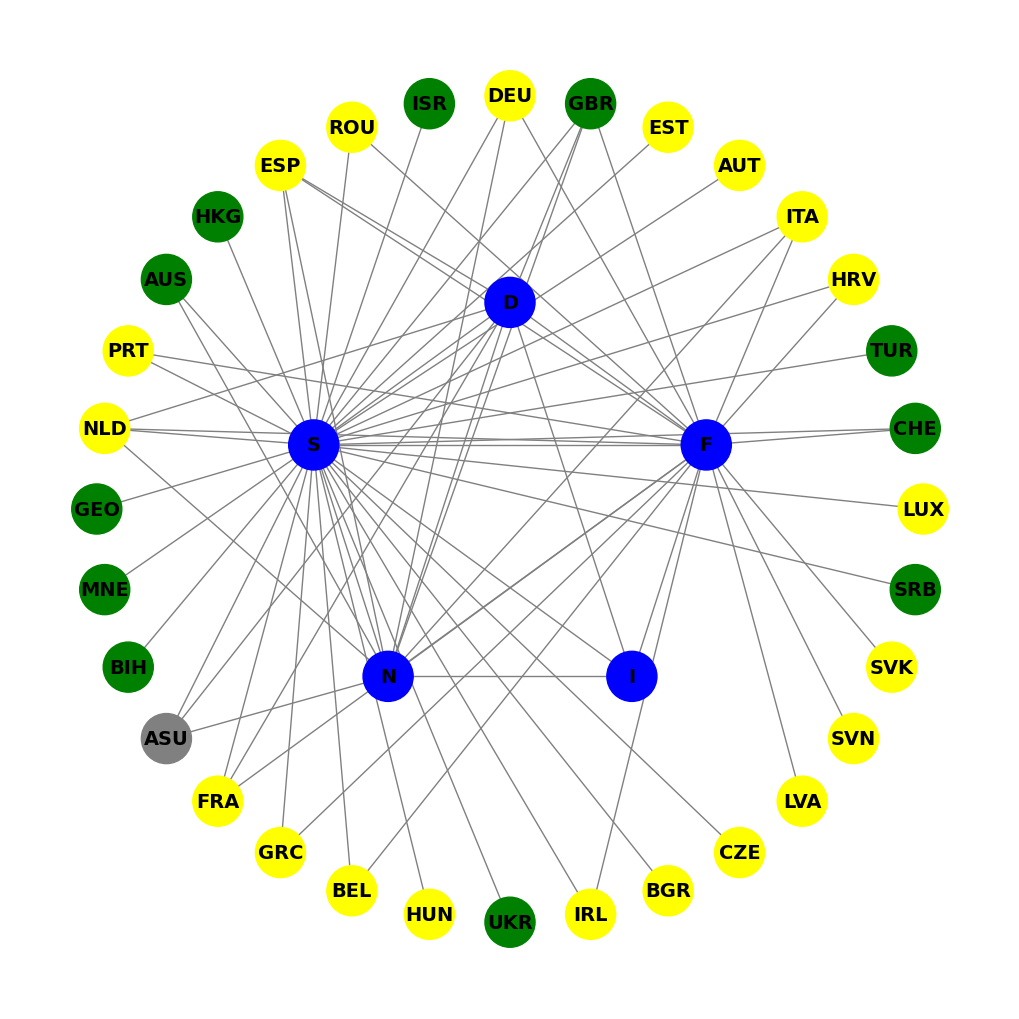

In [202]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
network_df = pd.read_csv("data/networks_assignment.csv")

# Extract labels (first column)
labels = network_df.columns[1:].tolist()

# Define node groups and colors
blue_nodes = ["D", "F", "I", "N", "S"]
green_nodes = ["BIH", "GEO", "ISR", "MNE", "SRB", "CHE", "TUR", "UKR", "GBR", "AUS", "HKG", "USA"]
yellow_nodes = ["AUT", "BEL", "BGR", "HRV", "CZE", "EST", "FRA", "DEU", "GRC", "HUN", "IRL", "ITA", 
                "LVA", "LUX", "NLD", "PRT", "ROU", "SVK", "SVN", "ESP"]

# Convert the adjacency matrix into a dictionary format
connections = {}
for index, row in network_df.iterrows():
    node = row["LABELS"]  # First column contains node labels
    connections[node] = {labels[i]: row[i + 1] for i in range(len(labels)) if row[i + 1] > 0}

# Create the graph
G = nx.Graph()
for node, neighbors in connections.items():
    for neighbor, weight in neighbors.items():
        G.add_edge(node, neighbor, weight=weight)

# Generate positions for pentagram nodes
pentagram_points = [(0, 1), (0.95, 0.31), (0.59, -0.81), (-0.59, -0.81), (-0.95, 0.31)]
pentagram_positions = {n: pos for n, pos in zip(blue_nodes, pentagram_points)}

# Arrange outer nodes by color groups sequentially
ordered_outer_nodes = green_nodes + yellow_nodes
outer_positions = nx.circular_layout(ordered_outer_nodes, scale=2)

# Include any missing nodes (such as ASU) in the circular layout
all_outer_nodes = set(G.nodes()) - set(pentagram_positions)
outer_positions = nx.circular_layout(list(all_outer_nodes), scale=2)

# Combine all positions
positions = {**pentagram_positions, **outer_positions}

# Define colors for the nodes
node_colors = {n: "blue" for n in blue_nodes}
node_colors.update({n: "green" for n in green_nodes})
node_colors.update({n: "yellow" for n in yellow_nodes})
colors = [node_colors.get(n, "gray") for n in G.nodes()]

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos=positions, with_labels=True, node_color=colors, edge_color="gray",
        node_size=1300, font_size=14, font_color="black", font_weight="bold")
plt.show()